# This jupyter notebook characterizes our approach to sovereignGMLP considering voting options from an initial dataset. 

### STEP 1: We import the "master file" of principles. In our case dummy-data.xlsx 

Notice: table must contain the following columns:

- "UMBRELLA" - which tells us the topic to which this principle belongs
- "PRINCIPLE" - which tells us the principle itself
- "DOCUMENT_ORIGIN" - which tells us the document of origin, basically where did we take this principle from
- "DATE" - "when was this principle added to the document"
- "FREQUENCY" - which tells us how often should this principle be sampled

In [161]:
import pandas as pd

# PATHS
PROJECT_PATH = "/Users/nicolasperezgonzalez/Desktop/projects/sovereignGMLP-datascience/"
EXPERIMENT_PATH = "/Users/nicolasperezgonzalez/Desktop/projects/sovereignGMLP-datascience/data/20231201-raw/experiment001-dummy-data.xlsx"

def load_excel_to_df(filepath):
    try:
        # Use the read_excel function from pandas with the 'skiprows' parameter
        # to skip the first row (index 0) which contains the column names.
        df = pd.read_excel(filepath)

        return df
    except Exception as e:
        print(f"Error loading the Excel file: {e}")
        return None

df = load_excel_to_df(experiment_filepath)

if df is not None:
    print('This is what the head of our dataframe looks like\n\n')
    print(df.head())  

This is what the head of our dataframe looks like


           UMBRELLA                                          PRINCIPLE  \
0              bias                           have you mitigated bias?   
1              bias                  have you checked for racial bias?   
2           testing  have you tested with dummy data? Meaning relev...   
3           testing                     have you tested with patients?   
4  intended purpose  did you define an intended purpose for your de...   

  DOCUMENT_ORIGIN       DATE FREQUENCY  
0            nico 2023-12-07    normal  
1           fiona 2023-12-07    normal  
2            nico 2023-12-07    normal  
3           fiona 2023-12-07    normal  
4            nico 2023-12-07    normal  


### STEP 2: Generate experiments

First, in order to generate voting we need to assign a numerical value to the STR=FREQUENCY

In [63]:
def transform_frequency_to_numerical(df):
    # Define a mapping dictionary for the "frequency" column
    frequency_mapping = {"normal": 1, "high": 2, "very high": 3}
    
    # Create a new column "freq_num" with the transformed values
    df["FREQ_NUM"] = df["FREQUENCY"].map(frequency_mapping)
    
    return df

df = transform_frequency_to_numerical(df)
df.head(1)

,UMBRELLA,PRINCIPLE,DOCUMENT_ORIGIN,DATE,FREQUENCY,FREQ_NUM
0,bias,have you mitigated bias?,nico,2023-12-07,normal,1


In [95]:
import numpy as np

def weighted_random_sampling(df, num_samples=1):
    # Create a weight array based on the "FREQ_NUM" column
    print(df.head(1))
    weights = df["FREQ_NUM"].apply(lambda x: int(x))
    
    # Normalize the weights to make them sum to 1
    weights = weights / weights.sum()
    
    # Sample a single row randomly using the weights
    sampled_indices = np.random.choice(df.index, size=num_samples, p=weights, replace=False)
    
    # Extract the sampled row as a DataFrame
    sampled_rows = df.loc[sampled_indices]
    
    return sampled_rows


def transform_rows_for_comparison(sampled_df):
    if sampled_df.shape[0] != 2:
        raise ValueError("Input DataFrame must have exactly two rows.")
    
    # Extract the "PRINCIPLE" values from both rows
    option_1_value = sampled_df.iloc[0]["PRINCIPLE"]
    option_2_value = sampled_df.iloc[1]["PRINCIPLE"]
    
    # Create a new DataFrame with one row and two columns
    result_df = pd.DataFrame({"option_1": [option_1_value], "option_2": [option_2_value]})
    
    return result_df

# THE FOLLOWING SCRIPT GENERATES FILES FOR EXPERTS TO LABEL:

# Define the column names as a list
column_names = ["option_1", "option_2"]
# Create an empty DataFrame with the specified column names
empty_df = pd.DataFrame(columns=column_names)

NUM_COMPARISONS_TO_MAKE = 10

for i in range(0,NUM_COMPARISONS_TO_MAKE):
    sampled_row = weighted_random_sampling(df, 2)
    result_df = transform_rows_for_comparison(sampled_row)
    empty_df = pd.concat([empty_df, result_df], ignore_index=True)

    new_column = []
    # Specify the position (index) where you want to insert the new column
    position = 0  # This will add the new column as the first column
    # Use the insert method to add the new empty column at the specified position
    
    empty_df["vote_left_or_right"] = None
    empty_df.to_excel(project_path + "data/experiment001-10comparison-expert-undefined.xlsx", index=False)

  UMBRELLA                 PRINCIPLE DOCUMENT_ORIGIN       DATE FREQUENCY  \
0     bias  have you mitigated bias?            nico 2023-12-07    normal   

   FREQ_NUM  
0         1  
                         option_1  \
0  have you tested with patients?   

                                            option_2 vote_left_or_right  
0  have you identified and mitigated legal risks ...               None  





  UMBRELLA                 PRINCIPLE DOCUMENT_ORIGIN       DATE FREQUENCY  \
0     bias  have you mitigated bias?            nico 2023-12-07    normal   

   FREQ_NUM  
0         1  
                         option_1  \
0  have you tested with patients?   
1        have you mitigated bias?   

                                            option_2 vote_left_or_right  
0  have you identified and mitigated legal risks ...               None  
1  did you define an intended purpose for your de...               None  





  UMBRELLA                 PRINCIPLE DOCUMENT_ORIGIN       DATE FRE

# Get statistics from the labeled files

### Read files labeled by experts

In [ ]:
labeled_data_path = project_path + "data/20231201-labeled/experiment001-10comparison-expert-matthias.xlsx"

df = load_excel_to_dataframe(labeled_data_path)

# The first we want to do is a graph. 
# The X axis is "how many samples/votes have we used in the algorithm
# The Y axis is "agreement with the TRUE-RANKING". 
# Agreement with the TRUE-RANKING is maximum when you use all the samples, and that is a horizontal line.

In [179]:
def update_rating_of_principles(principles, initialized_ratings, df_labels, num_votes=1):
    """
    This function takes initialized ratings, df_labels and a number of votes to be used
    OUTPUT: 
    """
            
    randomized_df = df_labels.sample(frac=1)#, random_state=42)
            
    for k in range(0, num_votes):
        # Take randomly a number within the index of the dataframe. Pick a vote, randomly.
        # Within that vote, get me option_a and option_b, identify the index of each one within my list
        option_1 = randomized_df.loc[k, "option_1"]
        option_2 = randomized_df.loc[k, "option_2"]
        vote = randomized_df.loc[k, "vote_left_or_right"]

        option1_index = principles.index(option_1)
        option2_index = principles.index(option_2)

        if vote=="left":
            # option 1 wins
            rating_principles[option1_index], rating_principles[option2_index] = rate_1vs1(rating_principles[option1_index],
                                                                                          rating_principles[option2_index])
        if vote=="right":
            # option 2 wins
            rating_principles[option2_index], rating_principles[option1_index] = rate_1vs1(rating_principles[option2_index],
                                                                                              rating_principles[option1_index])
        if vote=="none":
            # draw
            rating_principles[option1_index], rating_principles[option2_index] = rate_1vs1(rating_principles[option1_index],
                                                                                           rating_principles[option2_index],
                                                                                           drawn=True)
    muvalues_principles = [rating.mu for rating in rating_principles]

    # Now I sort the lists. Pair elements from both lists using zip, then sort by the values of list2
    sorted_pairs = sorted(zip(principles, muvalues_principles), key=lambda x: x[1])

    # Unpack the sorted pairs into separate lists
    sorted_principles, sorted_muvalues_principles = zip(*sorted_pairs) 
    sorted_principles = list(sorted_principles)
    sorted_muvalues_principles = list(sorted_muvalues_principles)

    return sorted_principles, sorted_muvalues_principles


In [180]:
from trueskill import Rating, quality_1vs1, rate_1vs1
import random
from scipy.stats import kendalltau

# Load dataframe with all principles
df_principles = load_excel_to_dataframe(experiment_filepath)
# get all available principles to a list
principles = df_principles["PRINCIPLE"].tolist()

# NOW I NEED TO OPEN THE LABEL DATA:
labeled_data_path = project_path + "data/20231201-labeled/experiment001-10comparison-expert-matthias-done.xlsx"
df_labels = load_excel_to_dataframe(labeled_data_path)
print(len(df_labels))

# Define a number of simulations
num_simulations = 1
data_dict = {}

for i in range(0, num_simulations):
    print(f"\n\n\nSimulation round number {i}")

    rating_principles = [Rating(mu=25, sigma=8.3) for _ in principles]
    print(len(df_labels))
    print('here')
    sorted_principles_std, sorted_mu_std = update_rating_of_principles(principles, rating_principles, df_labels, num_votes=len(df_labels))
    
    for j in range(0, len(df_labels)):
        # START NEW RATING SYSTEM FROM SCRATCH - INDEX "j" allows us to incrementally analyze what happens with the number of votes
        # I need to create "entities" within the TRUE-SKILL FRAMEWORK (each one is a Rating object).
        rating_principles = [Rating(mu=25, sigma=8.3) for _ in principles]

        sorted_principles, sorted_muvalues_principles = update_rating_of_principles(principles, rating_principles, df_labels, num_votes=j)
  
        # NOW WE CAN MEASURE - AGREEMENT BETWEEN THE EVAL WITH ALL CASES, AND THE EVAL WITH PARTIAL CASES. 
        tau, p_value = kendalltau(sorted_principles_std, sorted_principles)

        data_dict[str(j)] = tau  
        
        # Print the result
        print(f"Kendall's Tau: {tau}")

print(data_dict)

10



Simulation round number 0
10
here
Kendall's Tau: 0.3571428571428571
Kendall's Tau: -0.2857142857142857
Kendall's Tau: 0.07142857142857142
Kendall's Tau: 0.07142857142857142
Kendall's Tau: 0.21428571428571427
Kendall's Tau: -0.07142857142857142
Kendall's Tau: 0.42857142857142855
Kendall's Tau: 0.6428571428571428
Kendall's Tau: 0.9999999999999998
Kendall's Tau: 0.9999999999999998
{'0': 0.3571428571428571, '1': -0.2857142857142857, '2': 0.07142857142857142, '3': 0.07142857142857142, '4': 0.21428571428571427, '5': -0.07142857142857142, '6': 0.42857142857142855, '7': 0.6428571428571428, '8': 0.9999999999999998, '9': 0.9999999999999998}


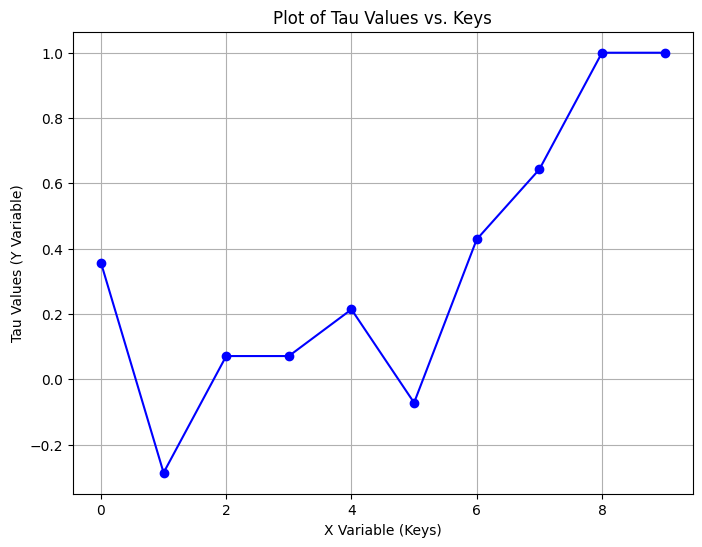

In [181]:
import matplotlib.pyplot as plt

# Extract keys and values from the dictionary
keys = [int(key) for key in data_dict.keys()]  # Convert keys to integers
values = list(data_dict.values())

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(keys, values, marker='o', linestyle='-', color='b')
plt.xlabel('X Variable (Keys)')
plt.ylabel('Tau Values (Y Variable)')
plt.title('Plot of Tau Values vs. Keys')
plt.grid(True)

# Show the plot
plt.show()